In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Adaptativo recursivo

## Questão 1

Escreva uma função recursiva `improve` que calcula a integral de $f$ no intervalo $[a,b]$ por divisões sucessivas,
e que pára quando o erro entre a estimativa "grande" e a estimativa "mais fina" fica menor do que `tol`.

O método usado pode variar, e ele é passado em argumento como `rule`, uma função que recebe uma função e um intervalo e retorna a aproximação neste intervalo.
Veja nas caixas abaixo qual o tipo de função que vai ser passado em `rule`.

In [2]:
def improve(rule, f,a,b, tol=1e-12):
    I = rule(f,a,b)
    m = (a+b)/2
    I1 = rule(f,a,m) + rule(f,m,b)
    if abs(I-I1) > tol:
        return improve(rule,f,a,m,tol) + improve(rule,f,m,b,tol)
    
    return I1

Vejamos se ela funciona:

In [3]:
def midpoint(f,a,b):
    m = (a+b)/2
    return f(m)*(b-a)

In [4]:
# deveria dar quase 1!
improve(midpoint, sin, 0, pi/2)

1.0000000005982468

In [5]:
assert( abs(improve(midpoint, sin, 0, pi/2) - 1) < 1e-8 )
assert( abs(improve(midpoint, exp, 0, 2) - (exp(2) - 1)) < 1e-8 )

In [6]:
gl2_cst = sqrt(1/3)/2
def gaussleg2(f,a,b):
    m = (a+b)/2
    h = (b-a)
    dx = h*gl2_cst
    x, y = m-dx, m+dx
    return h*(f(x) + f(y))/2

In [7]:
assert( abs(improve(gaussleg2, sin, 0, pi/2) - 1) < 1e-9 )
assert( abs(improve(gaussleg2, exp, 0, 2) - (exp(2) - 1)) < 1e-9 )

O método de 3 pontos (e ordem 6) de Gauss-Legendre, para ter um método a mais:

In [8]:
gl3_cst = sqrt(3/5)/2
def gaussleg3(f,a,b):
    h = (b-a)
    m = (a+b)/2
    dx = h*gl3_cst
    x,y = m-dx, m+dx
    return h*( 8*f(m) + 5*(f(x) + f(y)) )/18

In [9]:
assert( abs(improve(gaussleg3, sin, 0, pi/2) - 1) < 1e-10 )
assert( abs(improve(gaussleg3, exp, 0, 2) - (exp(2) - 1)) < 1e-10 )

## Questão 2: "vetorizando"

Para simplificar a nossa vida futura, escreva a função `vector_improve` que
- pode receber um array (ou uma lista...) no último argumento (`tol`)
- e retorna o array correspondente das várias integrais assim obtidas

In [10]:
def vector_improve(rule, f,a,b, tols):
    I = []
    for tol in tols:
        I.append(improve(rule,f,a,b,tol))
    return array(I)

In [11]:
tols = logspace(-20,-10,num=30,base=2)
many_integrals = vector_improve(midpoint,sin,0,1,tols) 
assert isvector(many_integrals)
assert len(many_integrals) == 30

## Questão 3: erros reais

Como você pode suspeitar dos `asserts` acima, a tolerância `1e-12` não parece ser seguida:

In [12]:
abs(improve(midpoint, sin, 0, pi/2) - 1)

5.9824678544373455e-10

Usando o parâmetro `tol`, faça um gráfico do erro real em função de `tol`, para as três regras de integração: ponto médio, Gauss-Legendre(2) e Gauss-Legendre(3).

Faça um gráfico diferente para cada função, e não esqueça de comparar o erro real com a tolerância requisitada.

In [13]:
tols = logspace(-40,-10,num=30,base=2)

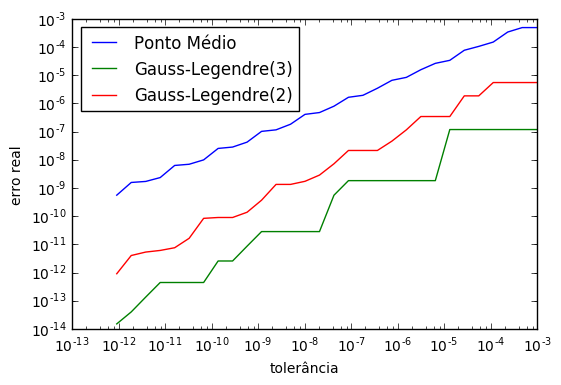

In [14]:
# Faça aqui o gráfico para o seno em [0,pi/2]
rules={ 'Ponto Médio':midpoint, 'Gauss-Legendre(2)':gaussleg2, 'Gauss-Legendre(3)':gaussleg3 }

def plota_erro(f,a,b,v):
    global rules,tols
    
    ylabel('erro real')
    xlabel('tolerância')
    v = array([v]*len(tols))
    for key,item in rules.items():
        erro = abs(v - vector_improve(item,f,a,b,tols))
        loglog(tols, erro, label=key)
    legend(loc=0)

plota_erro(sin,0,pi/2,1)

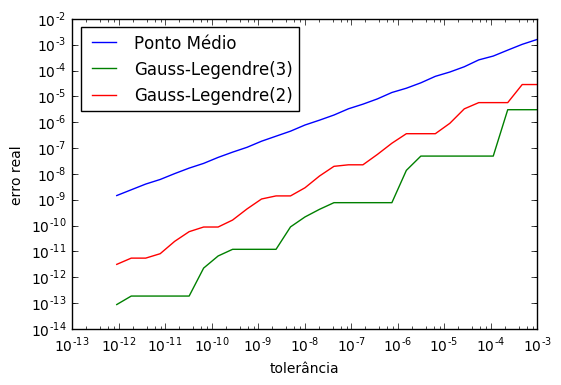

In [15]:
# Faça aqui o gráfico para a exponencial

plota_erro(exp,0,2,e**2-1)

Comente o que aconteceu.

Em cada chamada recursiva a `tol` era igual a inicial. Mas o intervalo passado na chamada recursiva tinha metade do tamanho. Com isso, a cada chamada se acrescentava um erro $\varepsilon \leq$ `tol`, a cada chamada. Ou seja, para um número total $n$ de chamadas, o erro seria $\varepsilon \leq n$`tol`.

O erro diminui a cada chamada, mas a tolerância também aumenta. Então o resultado que se quer não está sendo obtido.

## Questão 4: Contando o número de intervalos produzidos

Esperamos que os métodos de mais alta ordem usem menos intervalos (mas mais pontos em cada intervalo).
Modifique a função `improve` para que ela agora retorne também o número de intervalos usados.

Exemplos:
- Se você rodou uma vez apenas, a função deve retornar 2 (pois você vai fazer uma subdivisão para confirmar que o erro está pequeno!)
- Se a função começou no intervalo [0,1] e dividiu até aplicar a regra nos intervalos [0,1/4], [1/4,1/2], [1/2,5/8], [5/8,3/4], [3/4,1], você deve retornar 5.  Não leve em consideração que você também calculou nos intervalos [0,1], [0,1/2], [1/2,1], [1/2,3/4].

In [16]:
def improve_count(rule, f,a,b, tol=1e-12):
    m = (a+b)/2
    guess = rule(f,a,b)
    new_guess = rule(f,a,m) + rule(f,m,b)
    err = guess - new_guess
    if abs(err) < tol:
        return new_guess, 2
    else:
        left,  nleft  = improve_count(rule,f,a,m, tol)
        right, nright = improve_count(rule,f,m,b, tol)
        return left+right, nleft+nright

In [17]:
v,n = improve_count(midpoint, sin,0,1, tol=1e-2)
assert(n == 4)
v,n = improve_count(midpoint, sin,0,1, tol=1e-3)
assert(n == 6)

In [18]:
v,n = improve_count(gaussleg2, sin,0,1, tol=1e-3)
assert(n == 2)
v,n = improve_count(gaussleg3, sin,0,1, tol=1e-6)
assert(n == 2)

## Questão 5: gráficos

Vamos comparar o que é comparável: o número de vezes que $f$ é chamada e o erro final obtido.

Não esqueça que `improve_count` retorna apenas o número de intervalos produzidos, não o número de vezes que $f$ foi chamada.
Para simplificar, não estamos levando em conta o fato que $f$ foi chamada em outros intervalos também (pela forma como `improve_count` conta), mas apenas o "melhor possível" onde um "oráculo" (veja https://en.wikipedia.org/wiki/Oracle_(software_testing)) nos daria a decomposição de [a,b] em intervalos.

Primeiro, vetorize:

In [19]:
def improve(rule, f,a,b, tol=1e-12):
    I = rule(f,a,b)
    m = (a+b)/2
    I1 = rule(f,a,m) + rule(f,m,b)
    if abs(I-I1) > tol:
        return improve(rule,f,a,m,tol) + improve(rule,f,m,b,tol)
    
    return I1

def vector_improve_count(rule,f,a,b,tols):
    I, n = [], []
    for tol in tols:
        It, nt = improve_count(rule,f,a,b,tol)
        I.append(It)
        n.append(nt)
    return array(I), array(n)

E agora faça (de novo, para `sin` e para `exp`) um gráfico do erro de cada método em função do número de vezes que cada um calcula $f$.

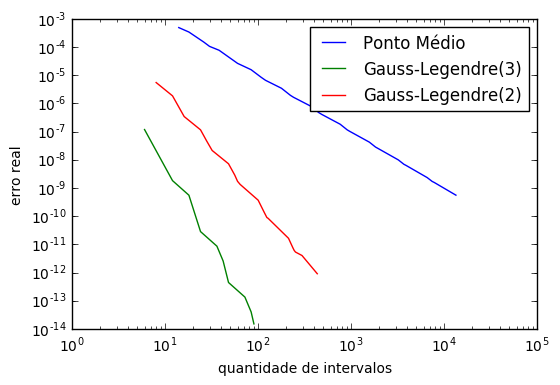

In [20]:
# seno em [0,pi/2]
rule_points = { 'Ponto Médio':1, 'Gauss-Legendre(2)':2, 'Gauss-Legendre(3)':3 }
def plota_erro_n(f,a,b,v):
    global rules,tols
    
    ylabel('erro real')
    xlabel('quantidade de intervalos')
    for key,item in rules.items():
        #erro,count = vector_improve_count_f(item,rule_points[key],f,a,b,tols)
        erro,count = vector_improve_count(item,f,a,b,tols)
        erro = abs(v - erro)
        count *= rule_points[key]
        loglog(count, erro, label=key)
    legend(loc=0)

plota_erro_n(sin,0,pi/2,1)

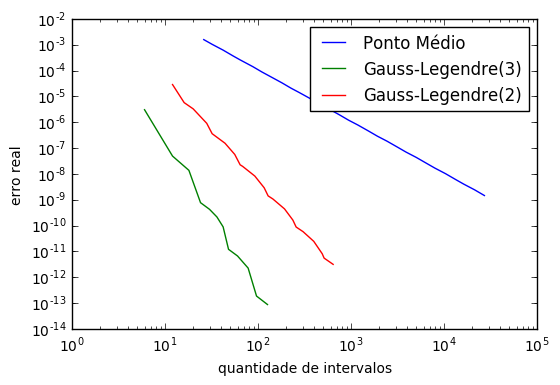

In [21]:
# exp em [0,2]
plota_erro_n(exp,0,2,e**2-1)

# Acertando o erro

Note que, se no intervalo [a,b] queremos um erro menor do que `tol`, precisamos que no intervalo
[a,m] e no intervalo [m,b] o erro seja menor do que `tol/2`.

## Questão 6: acertando a função

Assim, modifique (bem pouco!) a função `improve_count` (você não deve precisar refazer `vector_improve_count`...)
para que o erro nos intervalos "encaixados" seja também ele "adaptado" para que tol possa ser de fato uma garantia de erro (absoluto) máximo.

In [22]:
def improve_count(rule, f,a,b, tol=1e-12):
    m = (a+b)/2
    guess = rule(f,a,b)
    new_guess = rule(f,a,m) + rule(f,m,b)
    err = guess - new_guess
    if abs(err) < tol:
        return new_guess, 2
    else:
        left,  nleft  = improve_count(rule,f,a,m, tol/2)
        right, nright = improve_count(rule,f,m,b, tol/2)
        return left+right, nleft+nright

In [23]:
v,n = improve_count(midpoint, sin, 0, pi/2, tol=1e-8)
assert( abs(v - 1) < 1e-8 )
assert( n > 5000 )

v,n = improve_count(midpoint, exp, 0, 2, tol=1e-8)
assert( abs(v - (exp(2) - 1)) < 1e-8 )
assert( n > 20000 )

In [24]:
assert( abs(improve_count(gaussleg2, sin, 0, pi/2)[0] - 1) < 1e-12 )
assert( abs(improve_count(gaussleg3, exp, 0, 2)[0] - (exp(2) - 1)) < 1e-12 )

## Questão 7: uma integral mais difícil

Se as funções não oscilam muito, é relativamente fácil calcular uma integral bem precisa.
Também se as funções não têm derivadas muito grandes.

Vamos aqui olhar para uma combinação maléfica disso:

In [25]:
def malefica(x):
    return exp(x**3) * sin(10*x)

In [26]:
improve_count(gaussleg3, malefica, -4, 2, tol=1e-8)

(75.945956753759333, 366)

In [27]:
improve_count(gaussleg2, malefica, -4, 2, tol=1e-8)

(75.945956755584533, 3004)

In [28]:
# Não tente fazer 1e-8 em casa
improve_count(midpoint, malefica, -4, 2, tol=1e-6)

(75.945956758695502, 178880)

Vejamos o que a biblioteca do Python (que chama rotinas *mágicas* em FORTRAN) diz pra gente:

In [29]:
from scipy.integrate import quad
# Valor calculado, erro estimado
quad(malefica,-4,2)

(75.94595675562053, 7.409422899828305e-09)

Qual parte desta função é "pior"?
Faça alguns testes, e depois explique.

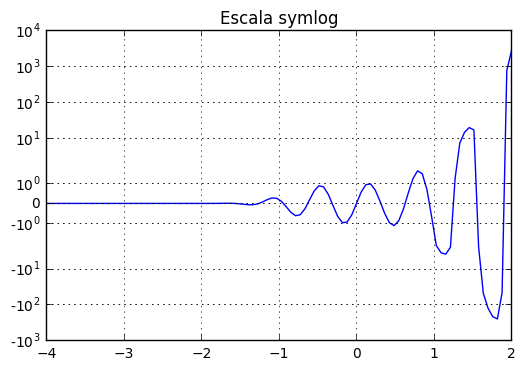

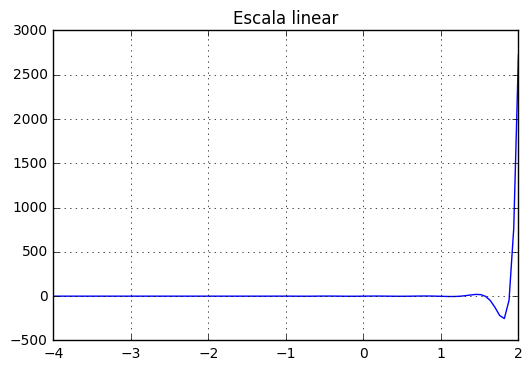

In [30]:
x = linspace(-4,2,100)
y = malefica(x)

figure(1)
grid(True,which='both')
yscale('symlog')
title("Escala symlog")
plot(x,y)

figure(2)
grid(True,which='both')
title("Escala linear")
plot(x,y);

In [31]:
improve_count(gaussleg3, malefica, -4,0, tol=1e-8/2), improve_count(gaussleg3, malefica, 0,2, tol=1e-8/2)

((-0.10009484326443512, 124), (76.046051598883764, 224))

In [32]:
improve_count(gaussleg2, malefica, -4,0, tol=1e-8/2), improve_count(gaussleg2, malefica, 0,2, tol=1e-8/2)

((-0.10009484325716556, 810), (76.046051598857488, 2066))

In [33]:
improve_count(midpoint, malefica, -4,0, tol=1e-6/2), improve_count(midpoint, malefica, 0,2, tol=1e-6/2)

((-0.10007418467871623, 13378), (76.046051600574458, 135492))

Essa função "piora" quando $x$ aumenta e "melhora" quando $x$ diminui.

O critério da quadratura adaptativa para subdividir um intervalo $[a,b]$ é verificar se, dado o ponto médio $m$, a soma da integral em $[a,m]$ com a integral em $[m,b]$ está próxima o suficiente da integral em $[a,b]$.

A função `malefica()` tem dois "pedaços": $e^{x^3}$ e $\sin(10x)$. O primeiro "pedaço" é uma função que cresce muito rápido com o aumento de $x$ e que decresce também muito rápido conforme $x$ diminui, chegando rapidamente a um módulo muito próximo do zero. O segundo pedaço é períodico, com período $\lambda = \displaystyle \frac{\pi}{10}$, ou seja, num intervalo real $[a,b]$ se $\displaystyle \vert b - a \vert > \frac{\pi}{20}$ então $\sin(10x)$ necessariamente troca de sinal em $[a,b]$.

Com base no parágrafo acima e no Teorema do Valor Intermediário, concluo que `malefica(x)` também é períodica, de período $\lambda = \displaystyle \frac{\pi}{10}$ e que sua amplitude cresce e decresce nos mesmos sentidos que $x$. A amplitude máxima é atingida nos pontos em que $\sin(10x) = 1$, ou seja, em que `malefica(x)` $= e^{x^3}$. Isso significa que o gráfico da função fica cada vez mais "pontudo" conforme $x$ aumenta e mais "reto" conforme $x$ diminui.

No fim, a amplitude fica tão pequena para $x \leq 0$ que a quantidade de intervalos necessária para calcular a integral quando $x \in [-4,0]$ é bem pequena se comparada com $x \in [0,2]$, já que no intervalo não-positivo o gráfico é mais "reto" e até um quadrado seria uma boa aproximação, enquanto na parte não-negativa e mais "pontuda", é necessário subdividir o intervalo várias vezes para aproximar bem as "pontas" mesmo que seja uma quadratura que use vários pontos como base.

A "melhor" parte é onde a amplitude da `malefica(x)` é menor ou igual a `tol`$/L$ sendo $L$ uma compensação para o tamanho do intervalo. A "pior" parte é onde a amplitude é maior que $L$`tol`.

## Questão 8: métodos uniformes

Escreva a função gl3_uniform que integra uma função $f$ no intervalo $[a,b]$ dividido em $n$ partes iguais.
Se inspire do código de `gaussleg3` (claro!).

In [34]:
def gl3_uniform(f,a,b,n=100):
    t = linspace(a,b,n+1)
    h = t[1]-t[0]
    meio_h = h/2
    dx = h*gl3_cst
    I = 0
    for t0 in t[:-1]:
        m = t0+meio_h
        I += h*( 8*f(m) + 5*(f(m-dx) + f(m+dx)) )/18
    return I

def gl3_uniform(f,a,b,n=100):
    t,h = a,(b-a)/n
    meio_h = h/2
    dx = h*gl3_cst
    I = 0
    for k in range(n):
        m = a + h*k + meio_h
        I += h*(8*f(m) + 5*(f(m-dx) + f(m+dx)))/18
    return I

In [35]:
I_unif = gl3_uniform(malefica,-4,2,366)
assert (75.94 < I_unif < 75.97)

Agora, vamos comparar a integral com intervalos uniformes e a integral com intervalos "adaptados":

In [36]:
# Calculando uma "boa aproximação"
approx, n = improve_count(gaussleg3, malefica, -4, 2, tol=2e-12)
approx, n

(75.945956755620543, 1550)

In [37]:
I_adap, n_adap = improve_count(gaussleg3, malefica, -4, 2, tol=1e-8)
abs(I_unif - approx), abs(I_adap - approx)

(2.6539041186879331e-08, 1.8612098529047216e-09)

Comente

In [38]:
improve_count(gaussleg3, malefica, -4, 2, tol=1e-8)[1]

366

Com a mesma quantidade de intervalos a quadratura adaptativa consegue uma precisão maior que a quadratura uniforme. Isso se deve a como a divisão dos intervalos é feita: na quadratura uniforme todo o intervalo de integração é dividido __uniformemente__ (nããããão, sério?), enquanto na quadratura adaptativa um subintervalo só é divido se o erro associado à integração desse intervalo for maior que o estabelecido pela tolerância.

E enfim, vejamos quanto tempo cada uma leva:

In [39]:
%time improve_count(gaussleg3, malefica, -4, 2, tol=1e-8)

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 77.4 ms


(75.945956753759333, 366)

In [40]:
%time gl3_uniform(malefica,-4,2,366)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 21.6 ms


75.945956782159584

Comente as diferenças.
Em particular, se você escreveu `gl3_uniform` com cuidado (vetorizada) deve haver uma diferença de mais de uma ordem de magnitude...

Não consegui uma diferença tão grande como a descrita, mas minha quadratura uniforme levou em média $\displaystyle \frac{1}{3}$ do tempo da adaptativa. Atribuo essa diferença a algumas coisas que são feitas na adaptativa que não são feitas na uniforme, como: as chamadas recursivas (que tem um _overhead_ próprio), o cálculo dos parâmetros $h$, $dx$ e ponto médio (que é usado dentro da regra de integração e fora na função `improve()`).